# CS 497/597: Tensorflow With Mobilenet V2

### Group Name: The Convoluted

### Group Members:

- Carson Keller - carsonkeller@u.boisestate.edu 
- Niko Pedreza - nikopedraza@u.boisestate.edu
- Adam Torek - adamtorek@u.boisestate.edu 

## Purpose of the assignment:

To familiarize ourselves with Tensorflow and MobileNet V2 by training, tuning, and explaining how MobileNet V2 works by training it on both CIFAR100 and a dataset of our choosing.

In [129]:
# Import tensorflow and keras for deep learning
import tensorflow as tf
from tensorflow import keras

# Import matplotlib to graph results
import matplotlib.pyplot as plt

#Import numpy to store imported images
import numpy as np

In [130]:
#Suppress tensorflow warnings
tf.get_logger().setLevel('ERROR')

### Step 1: Data Preprocessing

In [3]:
# Import the training and test data for CIFAR100 and load
# the fine grained class labels so we can use all 100 classes

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

In [4]:
# Upscale the CIFAR100 x_train and x_test images from 32 x 32 to 80 x 80
# to upscale features for MobileNet V2 (which was trained on images with 224 x 224 pixels from the ImageNet dataset)
x_train = tf.cast(tf.image.resize(tf.convert_to_tensor(x_train), size=[96,96], method=tf.image.ResizeMethod.BICUBIC),dtype=tf.int32)
x_test = tf.cast(tf.image.resize(tf.convert_to_tensor(x_test), size=[96,96], method=tf.image.ResizeMethod.BICUBIC),dtype=tf.int32)

I0000 00:00:1726270661.703335    4953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726270661.781879    4953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726270661.782038    4953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726270661.784027    4953 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
# Print the shape of the training and testing images and labels
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 96, 96, 3)
(50000, 1)
(10000, 96, 96, 3)
(10000, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2..262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [31..269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7..260].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10..259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [44..256].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [34..257].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [22..265].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats

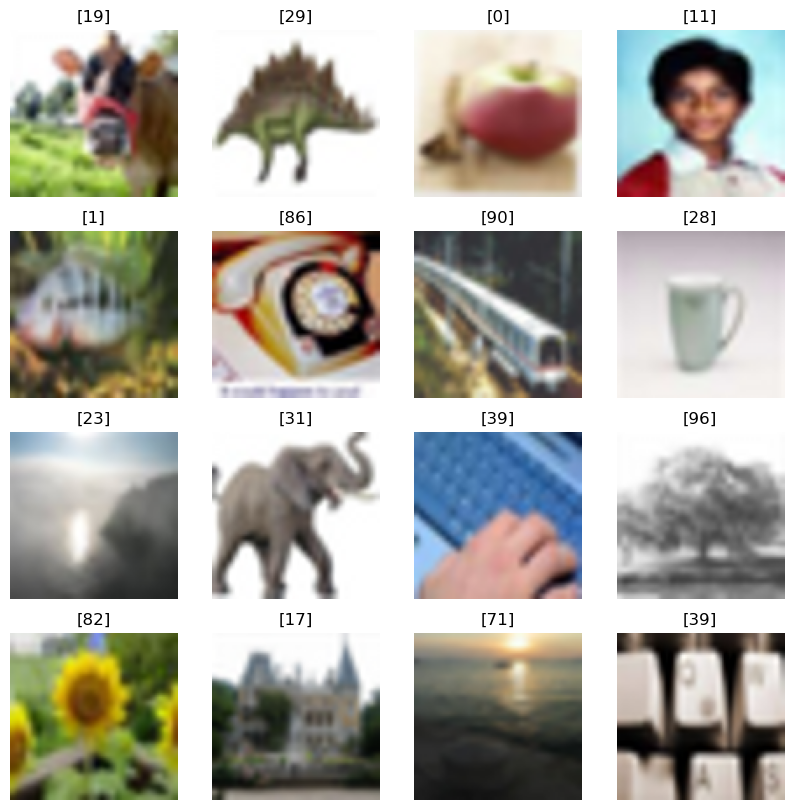

In [7]:
# Show 16 example images from the CIFAR100 dataset
plt.figure(figsize=(10,10))

for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis("off")

In [8]:
# Split the test dataset into testing and validation datasets for tuning and testing MobileNetVs2

division_point = int(x_test.shape[0]/2)
x_validation, y_validation = x_test[0:division_point], y_test[0:division_point]
X_test, Y_test = x_test[division_point:x_test.shape[0]], y_test[division_point:x_test.shape[0]]

In [9]:
# Run data augmentation to randomize incoming images and prevent overfitting with CIFAR100
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3..260].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2..260].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3..261].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3..261].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3..261].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3..260].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3..261].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0.

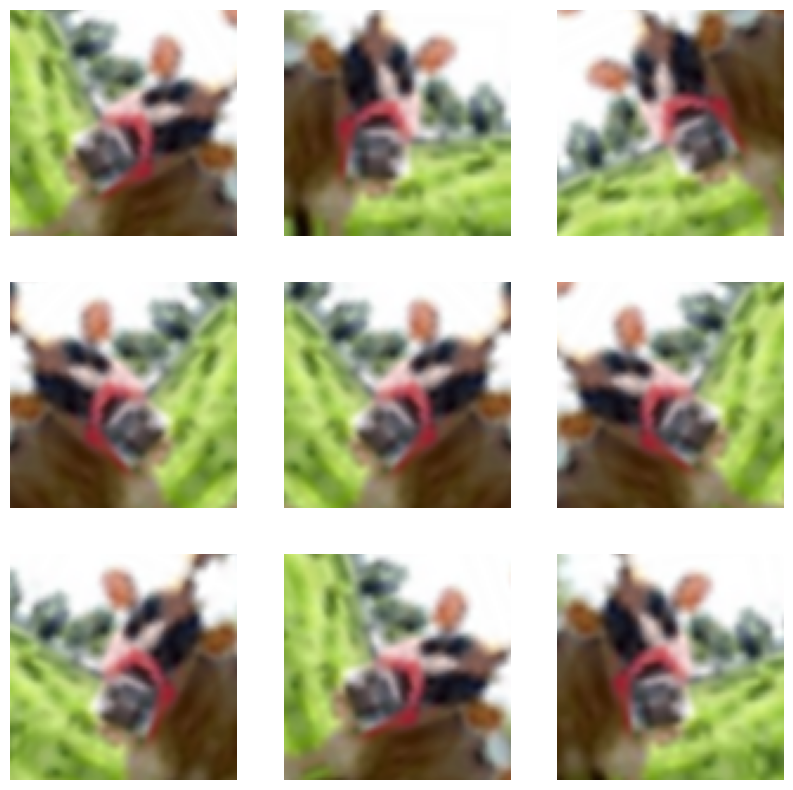

In [10]:
# Show example images from the random horizontal flip and rotation
# augmentation pipeline
data_preprocessing = keras.Sequential([
  keras.layers.Input(shape=x_train[0].shape),
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2),
])
plt.figure(figsize=(10, 10))
images = x_train[0:1]
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)

  augmented_image = data_preprocessing(images)
  plt.imshow(tf.cast(augmented_image[0], dtype=tf.int32))
  plt.axis('off')

In [11]:
# Normalize the test, train, and validation image pixels to be in the range of 0 to 1
# to prevent outliers from degrading MobileNet's accuracy
X_test = tf.cast(X_test, tf.float32) / 255.0
x_train = tf.cast(x_train, tf.float32) / 255.0
x_validation = tf.cast(x_validation, tf.float32) / 255.0

In [12]:
# Set a global batch size for the training, validation, and testing datasets for standardization
global_batch_size = 64

# Create training, validation, and testing data loaders from CIFAR100's training, validation, and testing splits
training_dataset = tf.data.Dataset.from_tensor_slices((x_train, keras.utils.to_categorical(y_train))).batch(batch_size=global_batch_size)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation, keras.utils.to_categorical(y_validation))).batch(batch_size=global_batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, keras.utils.to_categorical(Y_test))).batch(batch_size=global_batch_size)

### Step 2: Model Construction For MobileNet on CIFAR100 Dataset

In [99]:
# Construct a model built on top of MobileNetV2 with an
# input layer that takes in an image of the dimensions specified
# in x_data, sends said image into mobilenet, and then takes the
# output from mobilenet into a simple classifiation head that
# predicts what label said image is from a range of labels.
# This function will return the constructed (but not compiled)
# mobilenet V2 model
def build_mobilenet_model(x_data, y_data):

    # Prepare base MobileNet V2 model

    # EXCLUDED IMAGENET WEIGHTS AND TOP AND MADE BASE_MOBILENET TRAINABLE - CJK

    base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=x_data[0].shape, include_top=False)
    base_mobilenet.trainable = True

    # Get the prediction size of the data
    prediction_size = len(set(y_data.flatten()))

    # Create an intermediate dense layer between the average pooling layer and final prediction layer

    # TOOK OUT THIS HIDDEN OUTPUT LAYER - CJK

    # hidden_output_layer = keras.layers.Dense(200, activation='leaky_relu')

    # Create a prediction layer for each class in the CIFAR100 dataset
    prediction_layer = keras.layers.Dense(prediction_size, activation='softmax')

    # Create an input layer for the image itself
    input = tf.keras.Input(shape=x_data[0].shape)
    # Apply data augmentation pipeline

    # REMOVED DATA AUGMENTATION LAYER - CJK

    # x = data_augmentation(input)

    # Run the augmented image through MobileNet and train i

    # INPUT DATA DIRECTLY INTO MOBILENET

    x = base_mobilenet(input)

    # apply dropout to prevent overfitting
    # Average pooling layer
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.1)(x)
    # apply a hidden dense layer between the last MobileNet layer and prediction lay

    # REMOVED THIS HIDDEN OUTPUT LAYER - CJK

    # x = hidden_output_layer(x)

    # Get the final prediction of the model with a single fully connected layer
    output = prediction_layer(x)
    # Construct the model and pipeline
    model = keras.Model(input, output)

    # return constructed model
    return model

In [100]:
# Construct model based on MobileNetV2 that is adapted to the input size of
#CIFAR100's images and adds a classification head that takes MobileNet's output
# and turns it into a CIFAR100 prediction
model = build_mobilenet_model(x_train, y_train)

In [101]:
#3 Show the fully constructed model's parameter count and memory footprint including the base MobileNet V2 model
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │     1,152,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,410,084 (13.01 MB)

 Trainable params: 3,375,972 (12.88 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Step 3: Train Extended MobileNetV2 Model on CIFAR100 Dataset

In [102]:
# Set the learning rate, optimizer, loss function, and evaluation metrics for the model

# INCREASED YOUR BASE LEARNING RATE (THIS IS USUALLY THE TYPICAL STARTING VALUE) - CJK

base_learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"),
                       keras.metrics.Recall(name="recall"),
                       keras.metrics.Precision(name="precision"),
                       keras.metrics.F1Score(name="f1_score", average="weighted")])

In [103]:
# Train MobileNet for 10 epochs total with the CIFAR100 training images
# and use the validation dataset to evaluate MobileNet's training progress
# after each epoch with accuracy, precision, recall, and f1_score. The early stopping
# callback prevents the current model from being trained if the validation
# accuracy no longer improves by much.

# INCREASED THE NUMBER OF TRAINING EPOCHS, ADDED CALLBACKS, AND MONITORED VALIDATION LOSS INSTEAD OF VALIDATION ACCURACY - CJK

training_epochs = 30

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1, min_delta=1e-4)

callbacks = [early_stopping, reduce_lr_loss]

history = model.fit(training_dataset,
                    epochs=training_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.3875 - f1_score: 0.3856 - loss: 2.6880 - precision: 0.5685 - recall: 0.2764 - val_accuracy: 0.0212 - val_f1_score: 0.0156 - val_loss: 18.9523 - val_precision: 0.0184 - val_recall: 0.0178 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.6114 - f1_score: 0.6104 - loss: 1.3805 - precision: 0.7566 - recall: 0.5085 - val_accuracy: 0.0826 - val_f1_score: 0.0672 - val_loss: 8.2877 - val_precision: 0.0973 - val_recall: 0.0704 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.6887 - f1_score: 0.6879 - loss: 1.0625 - precision: 0.7986 - recall: 0.6035 - val_accuracy: 0.1052 - val_f1_score: 0.0834 - val_loss: 7.4845 - val_precision: 0.1581 - val_recall: 0.0842 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7380 - f1_score: 0.7374 - loss: 0.8692 - precision: 0.8251 - recall: 0.6663 - val_accuracy: 0.086

In [104]:
def graph_accuracy_loss(history, fine_tune_history=None):
    # Plot the validation and training accuracy and loss of MobileNetV2 across all training epochs
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    total_epochs = 0
    initial_epochs = 0
    if fine_tune_history is not None:
        total_epochs = len(history.history["accuracy"]) + len(fine_tune_history.history["accuracy"])
        initial_epochs = len(history.history["accuracy"])
    else:
        total_epochs = len(history.history["accuracy"])

    # Extract all of the metric history for plotting and add fine tuning history if it exists
    if fine_tune_history is not None:
        acc += fine_tune_history.history["accuracy"]
        val_acc += fine_tune_history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if fine_tune_history is not None:
         loss += fine_tune_history.history["loss"]
         val_loss += fine_tune_history.history['val_loss']

    precision = history.history['precision']
    val_precision = history.history['val_precision']

    if fine_tune_history is not None:
        precision += fine_tune_history.history["precision"]
        val_precision += fine_tune_history.history['val_precision']

    recall = history.history['recall']
    val_recall = history.history['val_recall']

    if fine_tune_history is not None:
      recall += fine_tune_history.history["recall"]
      val_recall += fine_tune_history.history['val_recall']

    f1_score = history.history['f1_score']
    val_f1_score = history.history['val_f1_score']

    if fine_tune_history is not None:
        f1_score += fine_tune_history.history["f1_score"]
        val_f1_score += fine_tune_history.history['val_f1_score']

    # Plot the training and validation accuracies for CIFAR100
    fig, ax = plt.subplots(nrows=5, ncols=1)
    fig.set_figwidth(10)
    fig.set_figheight(25)
    #plt.subplot(1, 1, 1)
    plt.xticks(range(0, total_epochs, 1))
    plt.ylim((0,1))

    ax[0].plot(acc, label='Training Accuracy')
    ax[0].plot(val_acc, label='Validation Accuracy')
    if fine_tune_history is not None:
        ax[0].plot([initial_epochs-1, initial_epochs-1],
                   plt.ylim(), label='Start Fine Tuning')
    ax[0].legend(loc='lower right')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_title('Training and Validation Accuracy For MobileNet V2 on CIFAR100 Dataset')

    #Plot the training and validation losses for CIFAR100
    #plt.subplot(2, 1, 2)
    ax[1].plot(loss, label='Training Loss')
    ax[1].plot(val_loss, label='Validation Loss')
    if fine_tune_history is not None:
        ax[1].plot([initial_epochs-1, initial_epochs-1],
                    ax[1].get_ylim(), label='Start Fine Tuning')
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Cross Entropy')
    ax[1].set_title('Training and Validation Loss')
    ax[1].set_xlabel('epoch')

    #Plot the training and validation precision for CIFAR100
    #plt.subplot(1, 2, 1)
    ax[2].plot(precision, label='Training Precision')
    ax[2].plot(val_precision, label='Validation Precision')
    if fine_tune_history is not None:
        ax[2].plot([initial_epochs-1, initial_epochs-1],
                    plt.ylim(), label='Start Fine Tuning')
    ax[2].legend(loc='upper right')
    ax[2].set_ylabel('Precision')
    ax[2].set_title('Training and Validation Precision')
    ax[2].set_xlabel('epoch')

    #Plot the training and validation recall for CIFAR100
    ax[3].plot(recall, label='Training Recall')
    ax[3].plot(val_recall, label='Validation Recall')
    if fine_tune_history is not None:
        ax[3].plot([initial_epochs-1, initial_epochs-1],
                    plt.ylim(), label='Start Fine Tuning')
    ax[3].legend(loc='upper right')
    ax[3].set_ylabel('Recall')
    ax[3].set_title('Training and Validation Recall')
    ax[3].set_xlabel('epoch')

    #Plot the training and validation f1 score for CIFAR100
    ax[4].plot(f1_score, label='Training F1 Score')
    ax[4].plot(val_f1_score, label='Validation F1 Score')
    if fine_tune_history is not None:
        ax[4].plot([initial_epochs-1, initial_epochs-1],
                    plt.ylim(), label='Start Fine Tuning')
    ax[4].legend(loc='upper right')
    ax[4].set_ylabel('F1 Score')
    ax[4].set_title('Training and Validation F1 Score')
    ax[4].set_xlabel('epoch')

    # Show both the training and validation accuracies
    plt.show()

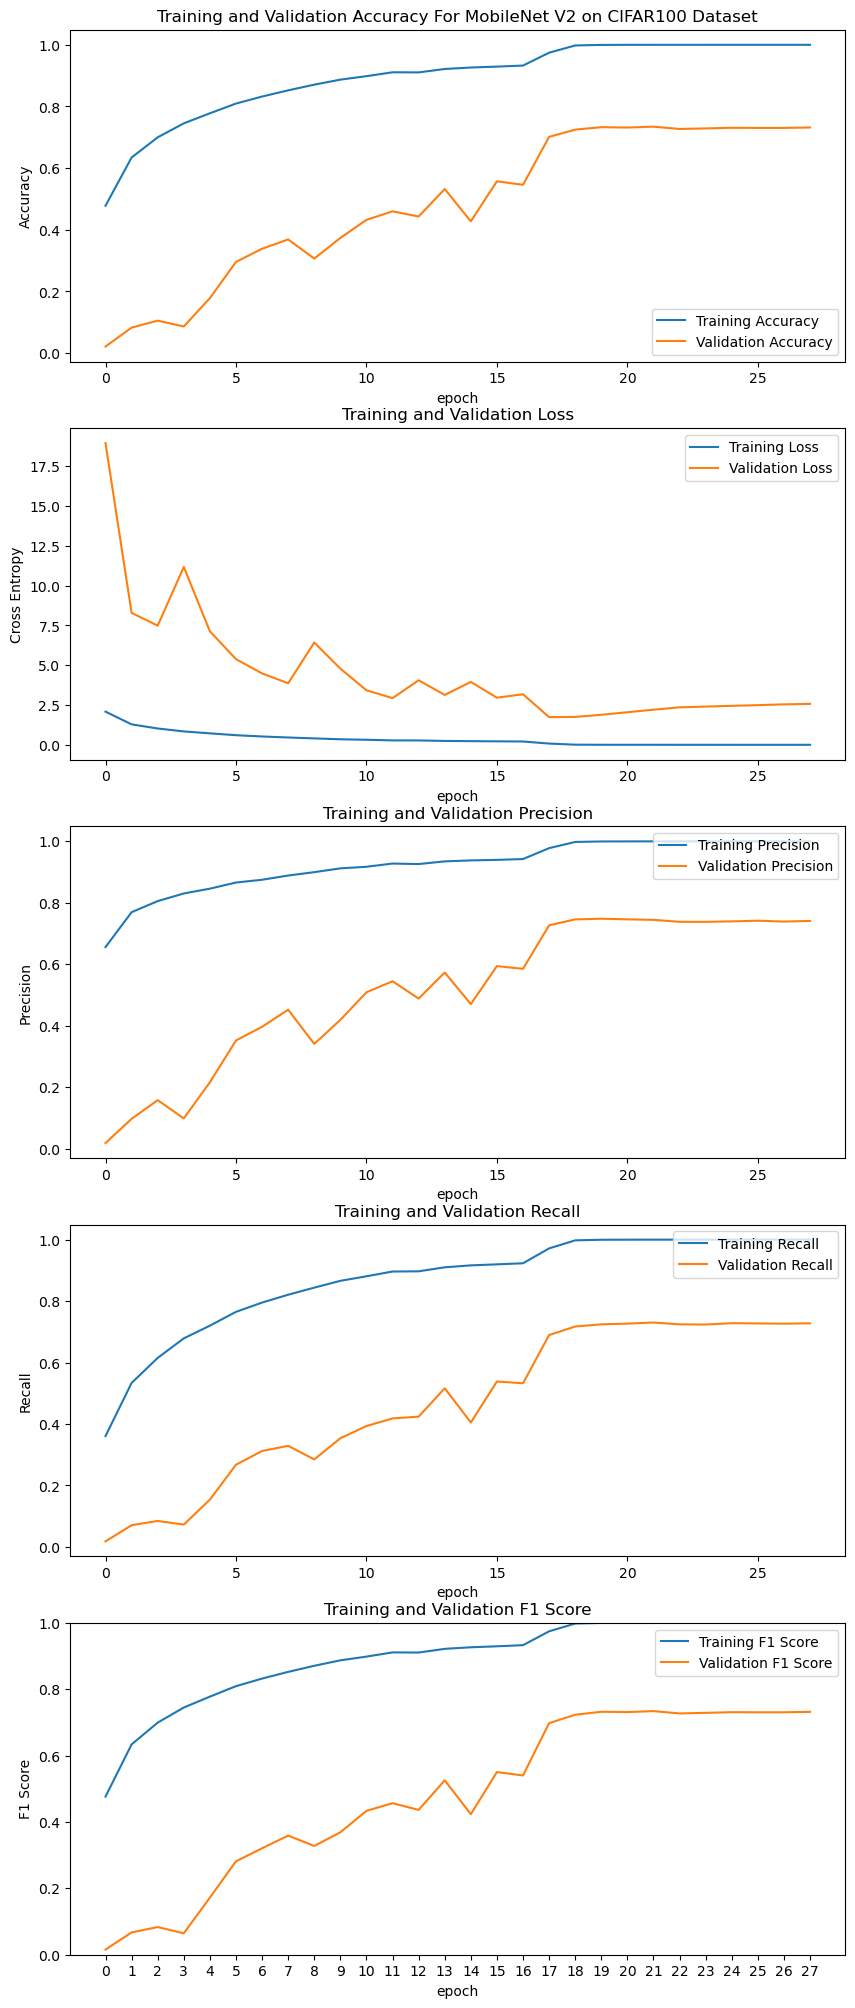

In [105]:
# Plot the validation and training accuracy and loss of MobileNetV2 across all training epochs
graph_accuracy_loss(history=history)

### Step 4: Fine Tuning For MobileNet V2 on CIFAR100 Dataset

In [106]:
#Compile the model that will be fine tuned with a lower learning rate
#And different optimizer to prevent overfitting
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"),
                       keras.metrics.Recall(name="recall"),
                       keras.metrics.Precision(name="precision"),
                       keras.metrics.F1Score(name="f1_score", average="weighted")])

In [107]:
# Add the fine tuning epochs to the training epochs
fine_tune_epochs = 10
total_epochs = training_epochs + fine_tune_epochs

In [108]:
# Fine tune both the MobileNet V2 base model and the current model
# Using the CIFAR100 training images for training and the validation
# images for evaluating training after each epoch. The early stopping
# callback prevents the current model from being trained if the validation
# accuracy no longer improves by much.
fine_tune_history = model.fit(training_dataset,
                              epochs=total_epochs,
                              initial_epoch=len(history.epoch),
                              validation_data=validation_dataset,
                              callbacks=callbacks)

Epoch 29/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 1.1500e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7288 - val_f1_score: 0.7291 - val_loss: 2.6092 - val_precision: 0.7385 - val_recall: 0.7258 - learning_rate: 1.0000e-04
Epoch 30/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 1.0775e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7282 - val_f1_score: 0.7283 - val_loss: 2.6150 - val_precision: 0.7379 - val_recall: 0.7254 - learning_rate: 1.0000e-04
Epoch 31/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 9.2123e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7250 - val_f1_score: 0.7250 - val_loss: 2.6393 - val_precision: 0.7349 - val_recall: 0.7224 - learning_rate: 1.0000e-04
Epoch 32/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 7.3080e-05 - precision: 1.0000 - recal

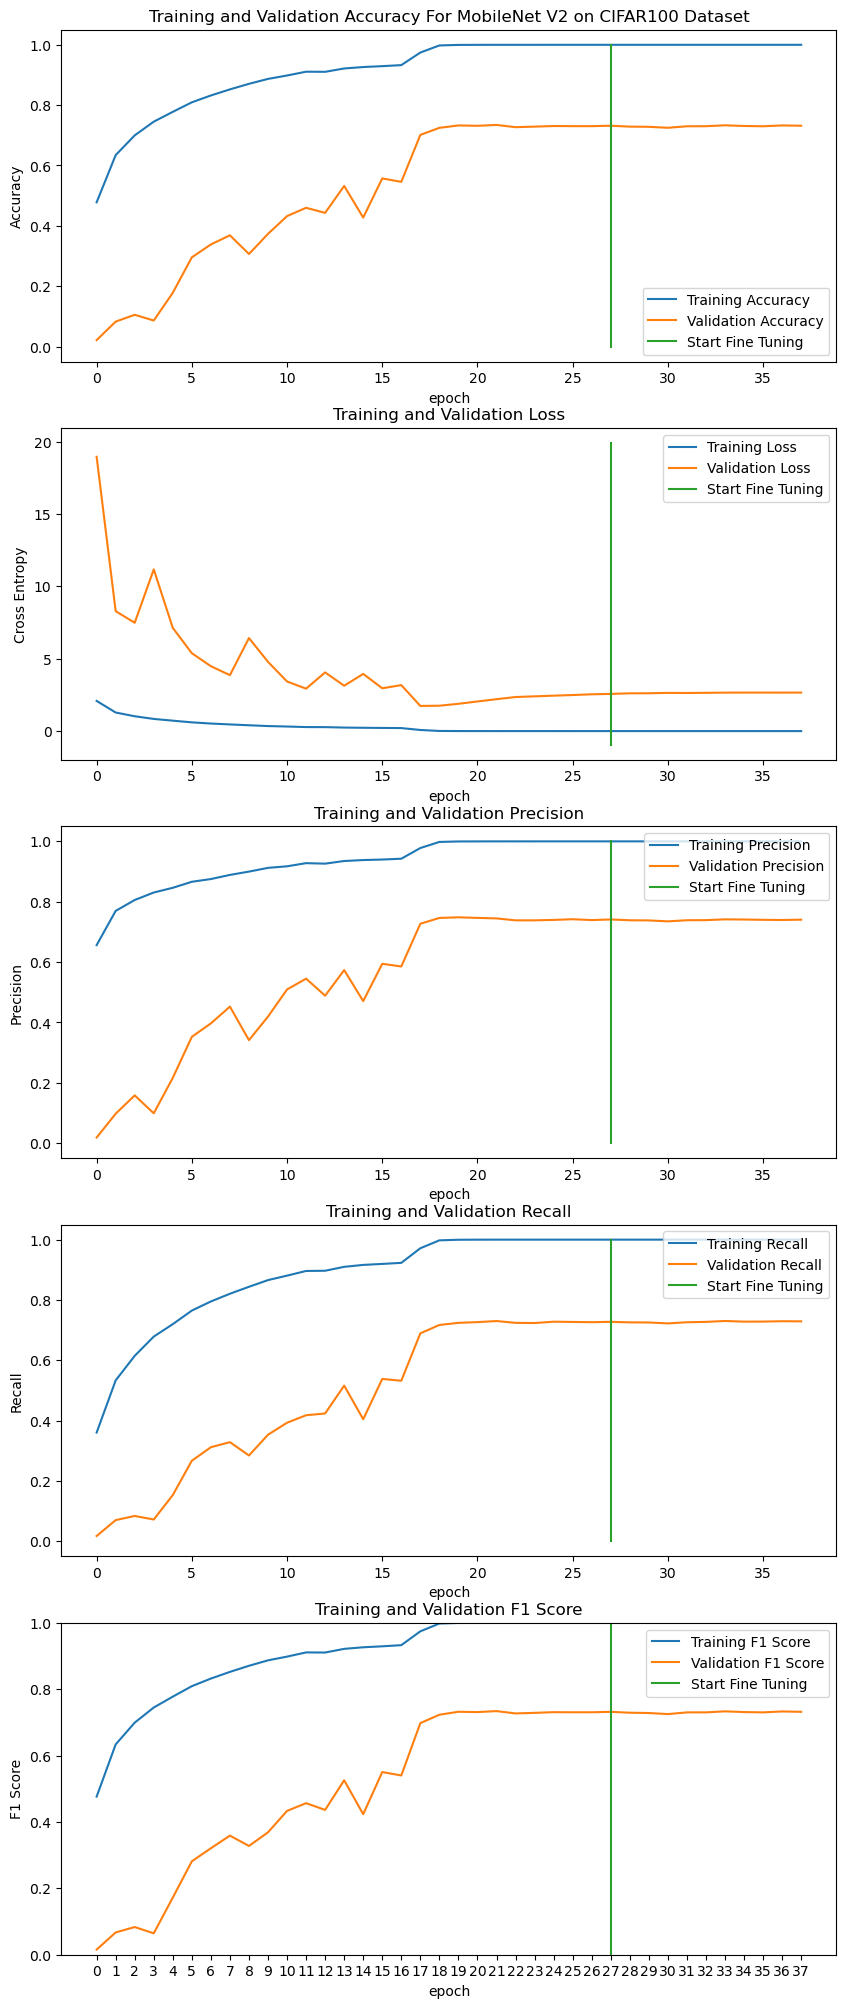

In [109]:
graph_accuracy_loss(history, fine_tune_history=fine_tune_history)

### Step 5: Evaluate Final Model on Test Dataset

In [110]:
# Show the accuracy, precison, recall, and f1 score of our MobileNet V2 model
# on the CIFAR100 test images
loss, accuracy, precision, recall, f1_score = model.evaluate(test_dataset)

print("Test Accuracy: " + str(accuracy))
print("Test Precision: " + str(precision))
print("Test Recall: " + str(recall))
print("Test F1 Score: " + str(f1_score))

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7283 - f1_score: 0.7276 - loss: 2.7257 - precision: 0.7355 - recall: 0.7255
Test Accuracy: 0.7343999743461609
Test Precision: 0.7318000197410583
Test Recall: 0.7409882545471191
Test F1 Score: 0.7338066697120667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10980392..1.0196079].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015686275..1.0156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003921569..0.9411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003921569..0.7607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03137255..1.0470588].


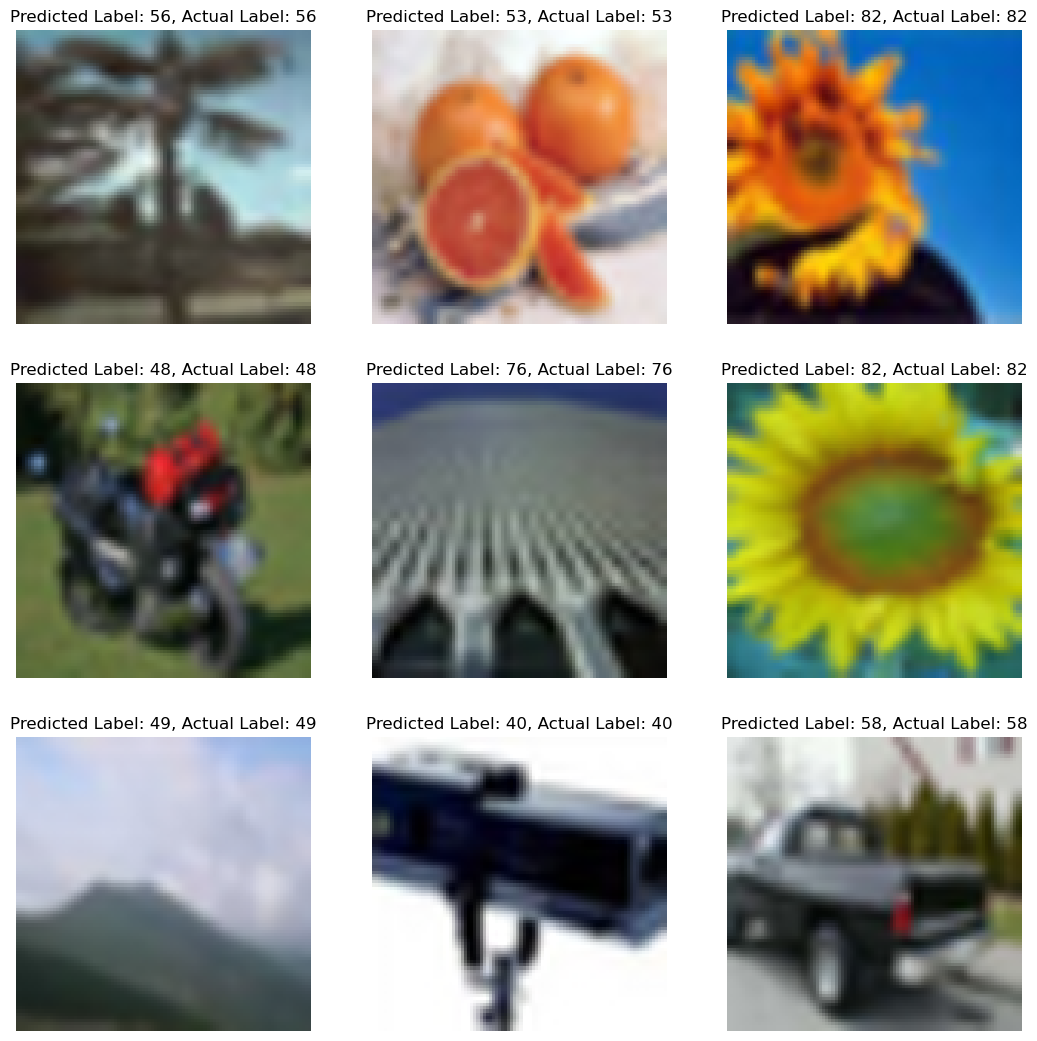

In [111]:
# Get some example images from the CIFAR100 test dataset to show MobileNet's predicted label
# next to their actual label
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
# Show 9 images from the CIFAR100 test dataset
plt.figure(figsize=(13, 13))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title("Predicted Label: " + str(np.argmax(predictions[i])) + ", Actual Label: " + str(np.argmax(label_batch[i])))
  plt.axis("off")

## Part 2: MobileNet V2 with Fashion-MNIST Data

### Step 1: Data Preprocessing

In [33]:
# Import the training and test data for fashion-MNIST and load 
# all 10 classes from Fashion-MNIST
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = keras.datasets.fashion_mnist.load_data()

In [34]:
# Convert Fashion-MNIST images to RGB format so that MobileNet-V2 can fit them
x_train_fashion = tf.image.grayscale_to_rgb(tf.expand_dims(tf.convert_to_tensor(x_train_fashion), axis=3))
x_test_fashion =  tf.image.grayscale_to_rgb(tf.expand_dims(tf.convert_to_tensor(x_test_fashion), axis=3))

In [35]:
# Upscale the Fashion-MNIST x_train and x_test images from 32 x 32 to 80 x 80
# to upscale features for MobileNet V2 (which was trained on images with 224 x 224 pixels from the ImageNet dataset) 
x_train_fashion = tf.cast(tf.image.resize(x_train_fashion, size=[56,56], method=tf.image.ResizeMethod.BICUBIC),dtype=tf.int32)
x_test_fashion = tf.cast(tf.image.resize(x_test_fashion, size=[56,56], method=tf.image.ResizeMethod.BICUBIC),dtype=tf.int32)

In [36]:
# Show the shape of the Fashion-MNIST images after RGB conversion and upscaling
print(x_train_fashion.shape)
print(y_train_fashion.shape)
print(x_test_fashion.shape)
print(y_test_fashion.shape)

(60000, 56, 56, 3)
(60000,)
(10000, 56, 56, 3)
(10000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-28..261].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-27..261].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-20..257].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-25..255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-25..279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-20..247].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-24..258].
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

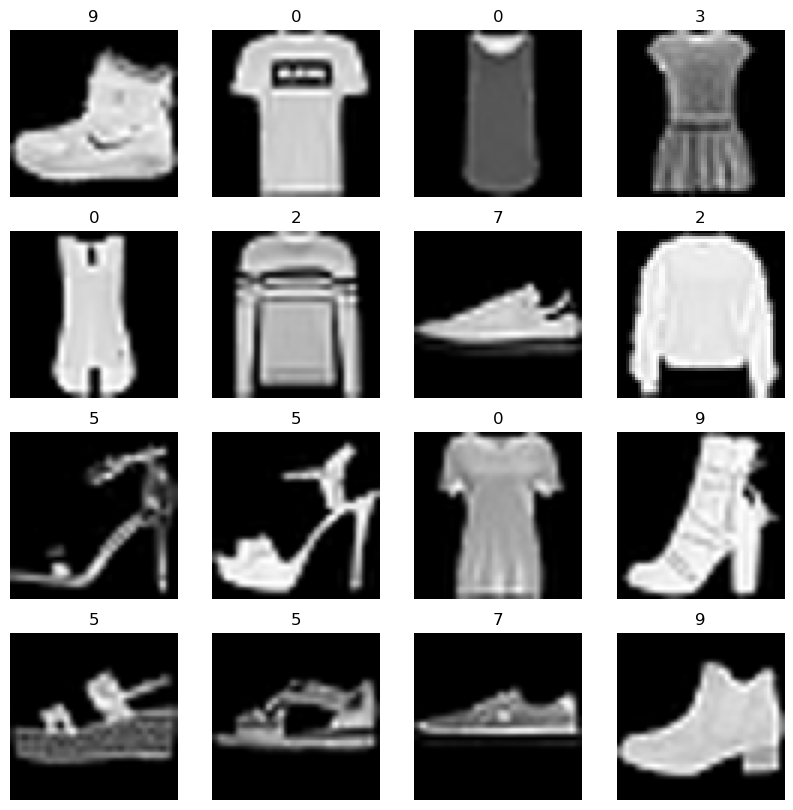

In [37]:
# Show 16 example images from the Fashion-MNIST dataset
plt.figure(figsize=(10,10))

for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(x_train_fashion[i])
    plt.title(y_train_fashion[i])
    plt.axis("off")

In [38]:
# Split the test dataset into testing and validation datasets for tuning and testing MobileNetVs2

division_point = int(x_test_fashion.shape[0]/2)
x_validation_fashion, y_validation_fashion = x_test_fashion[0:division_point], y_test_fashion[0:division_point]
X_test_fashion, Y_test_fashion = x_test_fashion[division_point:x_test.shape[0]], y_test_fashion[division_point:x_test.shape[0]]

In [39]:
# Normalize the test, train, and validation image pixels to be in the range of 0 to 1
# to prevent outliers from degrading MobileNet's accuracy
X_test_fashion = tf.cast(X_test_fashion , tf.float32) / 255.0
x_train_fashion  = tf.cast(x_train_fashion , tf.float32) / 255.0
x_validation_fashion  = tf.cast(x_validation_fashion , tf.float32) / 255.0

In [40]:
# Create training, validation, and testing data loaders from Fashion-MNIST's training, validation, and testing splits
training_dataset_fashion = tf.data.Dataset.from_tensor_slices((x_train_fashion, keras.utils.to_categorical(y_train_fashion))).batch(batch_size=global_batch_size)
validation_dataset_fashion = tf.data.Dataset.from_tensor_slices((x_validation_fashion, keras.utils.to_categorical(y_validation_fashion))).batch(batch_size=global_batch_size)
test_dataset_fashion = tf.data.Dataset.from_tensor_slices((X_test_fashion, keras.utils.to_categorical(Y_test_fashion))).batch(batch_size=global_batch_size)

### Step 2: Prepare MobileNet Model For Fashion-MNIST Dataset

In [112]:
# Build a MobileNet V2 model for the Fashion MNIST dataset
fashion_model = build_mobilenet_model(x_train_fashion, y_train_fashion)

/tmp/ipykernel_4953/3805002806.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=x_data[0].shape, include_top=False)


In [113]:
# Show the summary of the mobilenet model for Fashion-MNIST
fashion_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 56, 56, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        51,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,309,194 (8.81 MB)

 Trainable params: 2,275,082 (8.68 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Step 3: Train MobileNet on Fashion-MNIST Data

In [114]:
# Set the learning rate, optimizer, loss function, and evaluation metrics for the model
fashion_model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"),
                       keras.metrics.Recall(name="recall"),
                       keras.metrics.Precision(name="precision"),
                       keras.metrics.F1Score(name="f1_score", average="weighted")])

In [115]:
# Train MobileNet for 10 epochs total with the Fashion-MNIST training images
# and use the validation dataset to evaluate MobileNet's training progress
# after each epoch with accuracy, precision, recall, and f1_score. The early stopping
# callback prevents the current model from being trained if the validation
# accuracy no longer improves by much.
fashion_history = fashion_model.fit(training_dataset_fashion, 
                    epochs=training_epochs,
                    validation_data=validation_dataset_fashion, 
                    callbacks=callbacks)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.7895 - f1_score: 0.7890 - loss: 0.7025 - precision: 0.8469 - recall: 0.7349 - val_accuracy: 0.5286 - val_f1_score: 0.4698 - val_loss: 22.1338 - val_precision: 0.5297 - val_recall: 0.5278 - learning_rate: 0.0010
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8956 - f1_score: 0.8952 - loss: 0.2950 - precision: 0.9170 - recall: 0.8763 - val_accuracy: 0.8650 - val_f1_score: 0.8648 - val_loss: 0.6303 - val_precision: 0.8700 - val_recall: 0.8618 - learning_rate: 0.0010
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9149 - f1_score: 0.9147 - loss: 0.2403 - precision: 0.9303 - recall: 0.9009 - val_accuracy: 0.8754 - val_f1_score: 0.8776 - val_loss: 0.5557 - val_precision: 0.8798 - val_recall: 0.8728 - learning_rate: 0.0010
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9253 - f1_score: 0.9251 - loss: 0.2122 - precision: 0.9387 - recall: 0.9138 - val_accuracy: 0.855

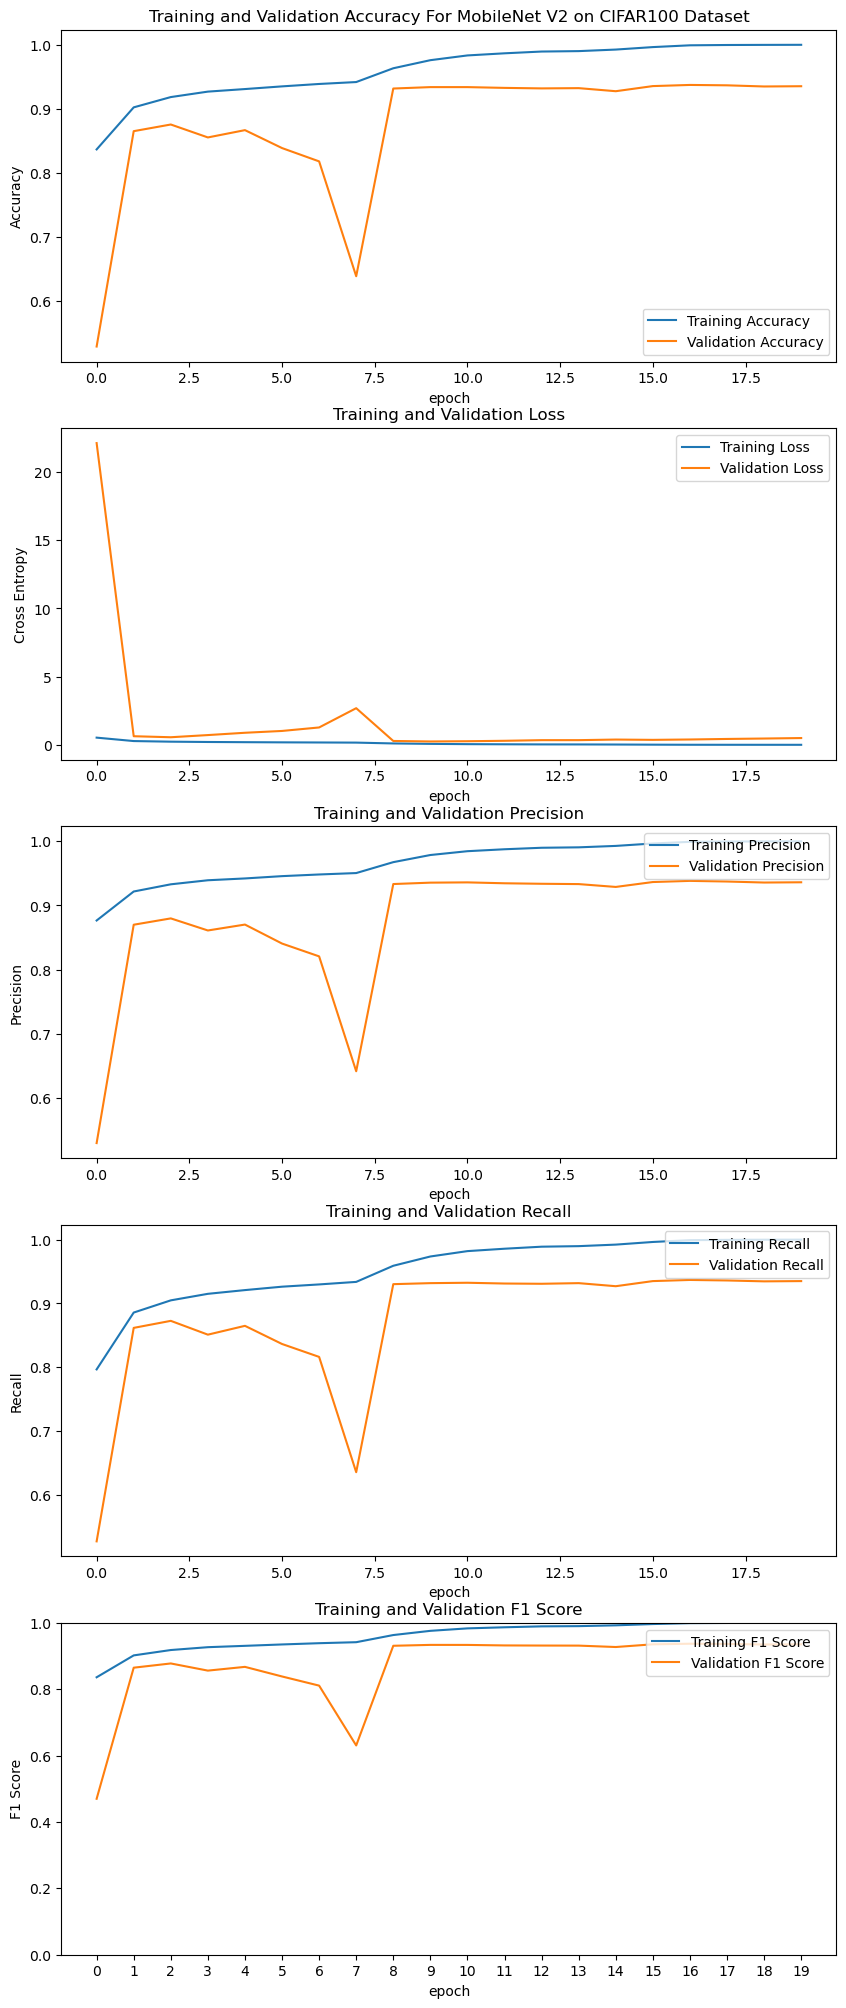

In [116]:
# Plot the validation and training accuracy and loss of MobileNetV2 across all training epochs
graph_accuracy_loss(history=fashion_history)

### Step 4: Fine-Tune MobileNet V2 on Fashion-MNIST Data

In [123]:
#Compile the model that will be fine tuned with a lower learning rate 
#And different optimizer to prevent overfitting
fashion_model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"),
                       keras.metrics.Recall(name="recall"),
                       keras.metrics.Precision(name="precision"),
                       keras.metrics.F1Score(name="f1_score", average="weighted")])

In [125]:
# Train MobileNet for 10 epochs total with the Fashion-MNIST training images
# and use the validation dataset to evaluate MobileNet's training progress
# after each epoch with accuracy, precision, recall, and f1_score. The early stopping
# callback prevents the current model from being trained if the validation
# accuracy no longer improves by much.
fine_tune_fashion_history = fashion_model.fit(training_dataset_fashion, 
                    epochs=total_epochs,
                    initial_epoch=len(fashion_history.epoch),
                    validation_data=validation_dataset_fashion, 
                    callbacks=callbacks)

Epoch 21/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.9999 - f1_score: 0.9999 - loss: 3.4248e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9346 - val_f1_score: 0.9344 - val_loss: 0.5687 - val_precision: 0.9351 - val_recall: 0.9344 - learning_rate: 1.0000e-04
Epoch 22/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 2.8802e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9348 - val_f1_score: 0.9348 - val_loss: 0.5984 - val_precision: 0.9355 - val_recall: 0.9346 - learning_rate: 1.0000e-04
Epoch 23/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 1.9116e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9352 - val_f1_score: 0.9351 - val_loss: 0.6138 - val_precision: 0.9357 - val_recall: 0.9350 - learning_rate: 1.0000e-04
Epoch 24/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 5.2981e-05 - precision: 1.0000 - recal

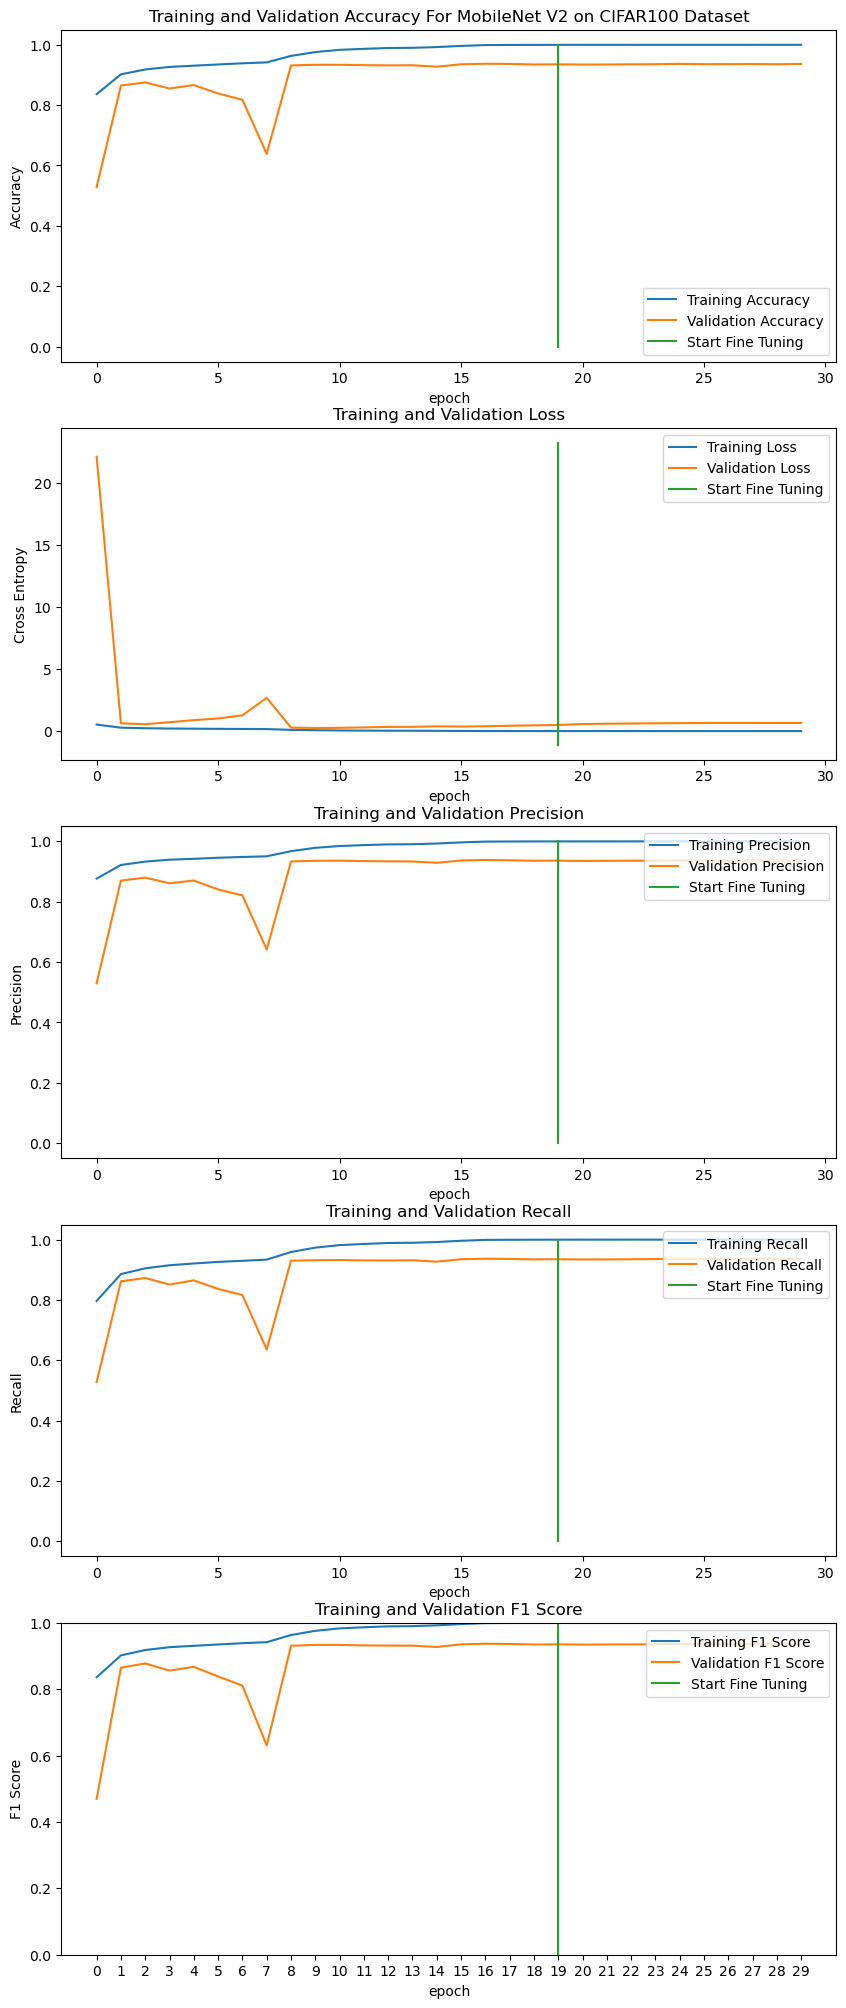

In [126]:
graph_accuracy_loss(fashion_history, fine_tune_history=fine_tune_fashion_history)

### Step 5: Get Final Results for MobileNet V2 on Fashion-MNIST Dataset

In [127]:
# Show the accuracy, precison, recall, and f1 score of our MobileNet V2 model
# on the Fashion-MNIST test images
loss, accuracy, precision, recall, f1_score = fashion_model.evaluate(test_dataset_fashion)

print("Test Accuracy: " + str(accuracy))
print("Test Precision: " + str(precision))
print("Test Recall: " + str(recall))
print("Test F1 Score: " + str(f1_score))

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9363 - f1_score: 0.9360 - loss: 0.5827 - precision: 0.9385 - recall: 0.9351
Test Accuracy: 0.9417999982833862
Test Precision: 0.9409999847412109
Test Recall: 0.9425080418586731
Test F1 Score: 0.9416245222091675


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07450981..1.0666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08627451..1.0509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12156863..1.0627451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.078431375..1.0588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09803922..0.98039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050980393..1.054902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

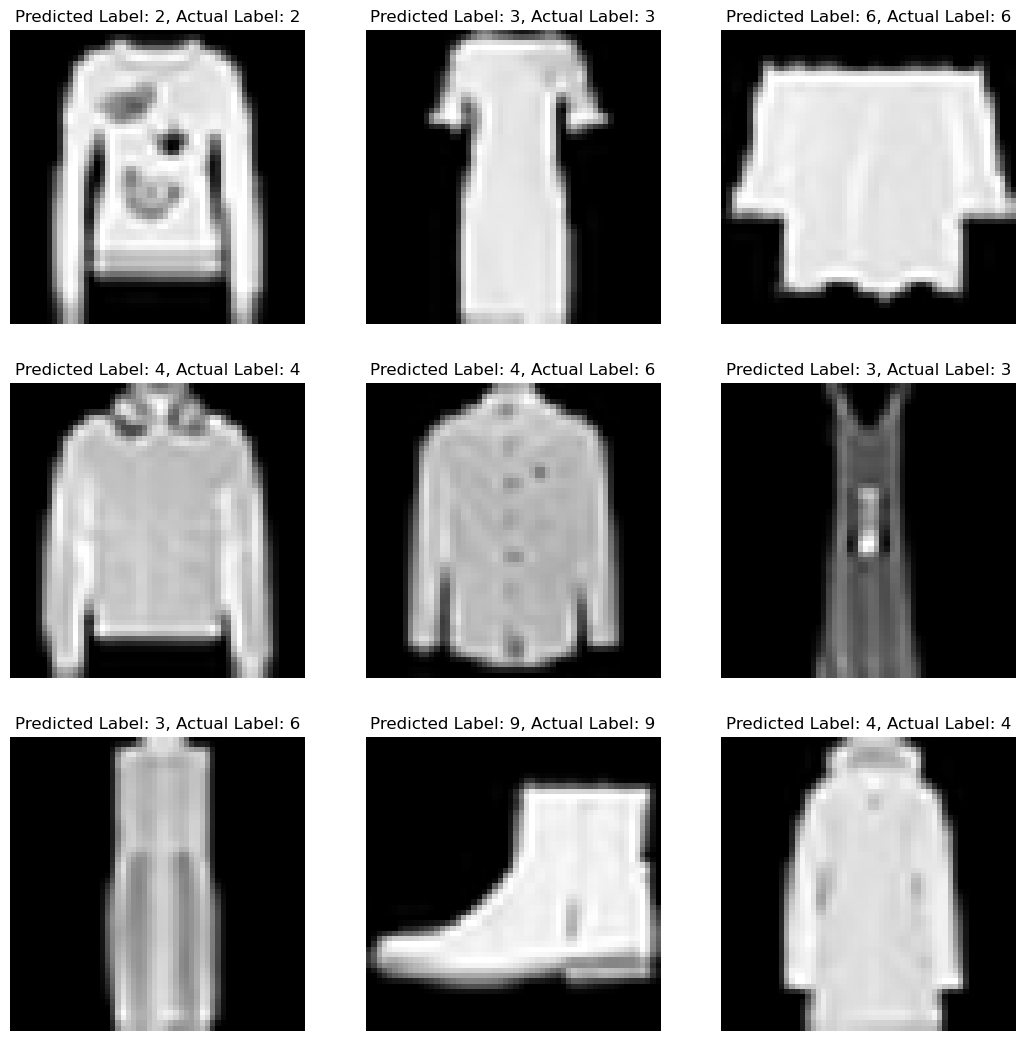

In [128]:
# Get some example images from the Fashion-MNIST test dataset to show MobileNet's predicted label
# next to their actual label
image_batch, label_batch = test_dataset_fashion.as_numpy_iterator().next()
predictions = fashion_model.predict_on_batch(image_batch)
# Show 9 images from the Fashion-MNIST test dataset
plt.figure(figsize=(13, 13))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title("Predicted Label: " + str(np.argmax(predictions[i])) + ", Actual Label: " + str(np.argmax(label_batch[i])))
  plt.axis("off")